In [352]:
import copy
import json
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm

from preprocessing import PreProcessing

## You'll see the data goes from 0 to 1 on each axis. The coordiante (0,0) is the top left, (1,1) is the bottom right, and (0.5,0.5) is the kick off point.

In [353]:
game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [354]:
game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

In [355]:
game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.45472,0.38709
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.49645,0.40656
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.55243,0.43269,0.50067,0.94322,0.43693,0.05002,0.37833,0.27383,0.53716,0.42556
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.55236,0.43313,0.50034,0.94391,0.43644,0.05038,0.37756,0.27473,0.55346,0.42231
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.55202,0.43311,0.50017,0.94434,0.43580,0.04977,0.37663,0.27543,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.10317,0.81976,0.19836,0.45137,0.29416,0.48874,0.35600,0.55371,0.03058,0.99726
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.10319,0.81960,0.19831,0.45182,0.29373,0.48836,0.35583,0.55283,0.03058,0.99726
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.10285,0.81944,0.19805,0.45200,0.29331,0.48800,0.35561,0.55254,0.03058,0.99726
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.10231,0.81944,0.19766,0.45237,0.29272,0.48789,0.35532,0.55243,0.03058,0.99726


In [356]:
game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.43313,0.31354,0.49889,-0.02263,0.50177,0.50145,0.49517,0.36234,0.50216,0.50376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46751,1.05000,0.44966,0.41572,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46790,1.05000,0.44983,0.41550,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46818,1.05000,0.44997,0.41485,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.46855,1.05000,0.45017,0.41515,0.26855,0.61845,0.36760,0.12496,0.40958,-0.03891


## Tracking for individual Players for the First Period

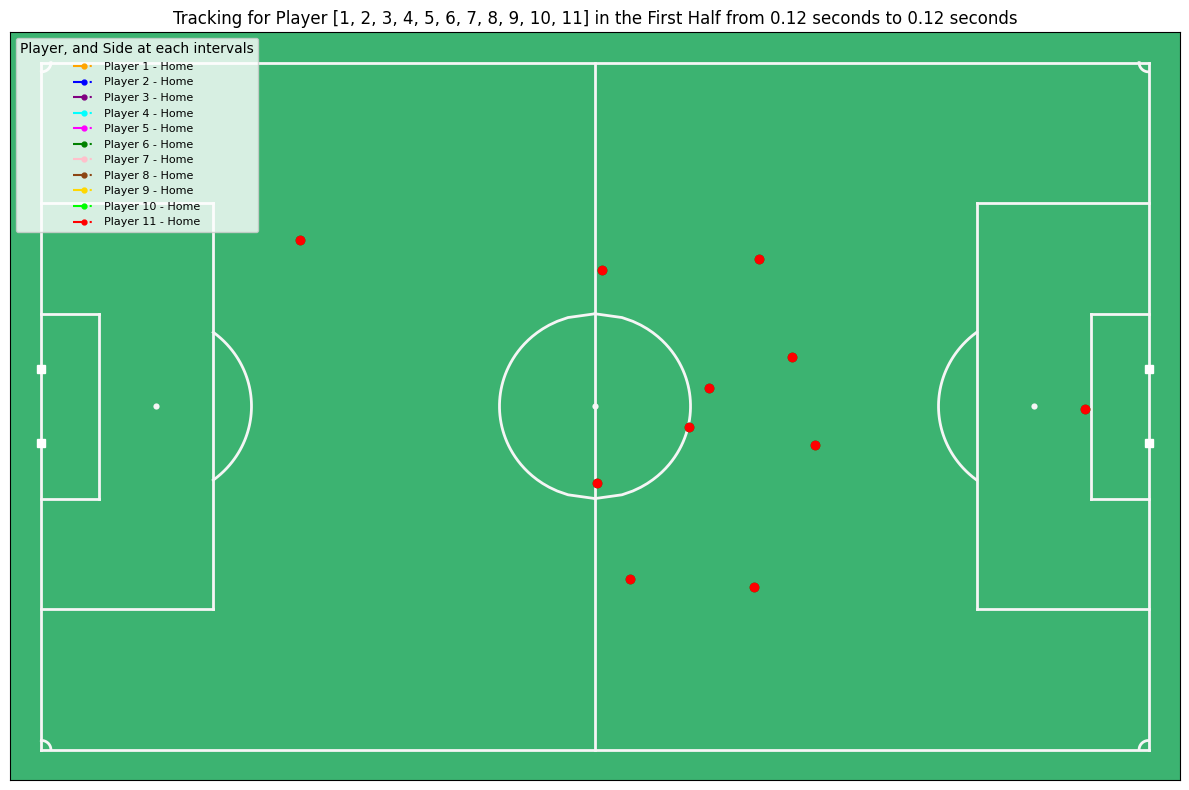

In [6]:
game_2_pre.player_visualization(game_2_data.iloc[2:3], players=[1,2,3,4,5,6,7,8,9,10,11], sides=["Home"]*11, plot_ball=False)

In [7]:
# player_tracking(period_1_data)
# player_tracking(period_1_data_home, [2])
# player_tracking(period_1_data_home, [5])
# player_tracking(period_1_data_home, [8])

# Adding extra features to dataset

In [357]:
vel_acc_game_1_data = game_1_pre.vel_acc(game_1_data)
vel_acc_game_2_data = game_2_pre.vel_acc(game_2_data)

In [358]:
vel_acc_game_1_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.00082,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.00096,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,1.151215,NaN
3,1.0,3.0,0.12,0.00114,0.48238,0.32648,0.65322,0.33701,0.48863,0.30927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123138,-0.701914
4,1.0,4.0,0.16,0.00121,0.48238,0.32622,0.65317,0.33687,0.48988,0.30944,...,0.011138,0.278458,0.019121,0.478033,0.015201,0.380019,0.029611,0.740275,0.415521,-17.690434
5,1.0,5.0,0.20,0.00129,0.48238,0.32597,0.65269,0.33664,0.49018,0.30948,...,0.008515,-0.065591,0.011560,-0.189042,0.022103,0.172568,0.029100,-0.012774,0.417319,0.044937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,2.0,145002.0,5800.08,0.90614,0.45355,0.30044,0.68311,0.34157,0.64598,0.31228,...,0.010198,0.098326,0.002704,0.017604,0.013613,0.028951,0.017509,0.062515,0.000000,0.000000
145003,2.0,145003.0,5800.12,0.90550,0.45355,0.30044,0.68311,0.34127,0.64583,0.31230,...,0.004031,-0.154173,0.011319,0.215377,0.014346,0.018330,0.022407,0.122446,0.000000,0.000000
145004,2.0,145004.0,5800.16,0.90492,0.45355,0.30044,0.68311,0.34089,0.64569,0.31214,...,0.009394,0.134075,0.007906,-0.085338,0.013829,-0.012921,0.009100,-0.332665,0.000000,0.000000
145005,2.0,145005.0,5800.20,0.90456,0.45356,0.30044,0.68311,0.34056,0.64552,0.31171,...,0.013500,0.102646,0.013440,0.138350,0.015004,0.029371,0.007754,-0.033653,0.000000,0.000000


In [359]:
vel_acc_game_2_data

,Period,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1.0,1.0,0.04,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,0.08,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,1.0,3.0,0.12,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,4.0,0.16,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,5.0,0.20,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2.0,141152.0,5646.08,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00875,0.06250,0.010000,-0.027615,0.0,0.0,0.0,0.0,0.0,0.0
141153,2.0,141153.0,5646.12,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00975,0.02500,0.006951,-0.076232,0.0,0.0,0.0,0.0,0.0,0.0
141154,2.0,141154.0,5646.16,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00700,-0.06875,0.016623,0.241798,0.0,0.0,0.0,0.0,0.0,0.0
141155,2.0,141155.0,5646.20,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,...,0.00925,0.05625,0.009014,-0.190219,0.0,0.0,0.0,0.0,0.0,0.0


In [360]:
game_1_ply_tra = vel_acc_game_1_data.iloc[:, 3:]
game_2_ply_tra = vel_acc_game_2_data.iloc[:, 3:]

In [361]:
game_2_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,NaN,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.94275,0.50413,0.64812,0.28605,0.67752,0.42803,0.69882,0.55606,0.64348,0.76253,...,0.00000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00875,0.06250,0.010000,-0.027615,0.0,0.0,0.0,0.0,0.0,0.0
141153,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00975,0.02500,0.006951,-0.076232,0.0,0.0,0.0,0.0,0.0,0.0
141154,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00700,-0.06875,0.016623,0.241798,0.0,0.0,0.0,0.0,0.0,0.0
141155,0.06285,0.51243,0.38499,0.15356,0.22558,0.41355,0.27142,0.32209,0.40837,0.14449,...,0.00925,0.05625,0.009014,-0.190219,0.0,0.0,0.0,0.0,0.0,0.0


In [362]:
# game_1_players, game_1_vel_acc = game_1_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_1_ply_tra.loc[:,"P_1_velocity":]
# game_2_players, game_2_vel_acc = game_2_ply_tra.loc[:,"Home-P_1-x":"Away-P_24-y"], game_2_ply_tra.loc[:,"P_1_velocity":]

In [363]:
game_1_player_data = game_1_pre.get_frames(game_1_ply_tra, columns=game_1_ply_tra.columns[0:46:2]).round(4).fillna(0)
game_2_player_data = game_2_pre.get_frames(game_2_ply_tra, columns=game_2_ply_tra.columns[0:46:2]).round(4).fillna(0)

In [364]:
game_1_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.0008,0.4824,0.0000,0.0000,0.3265,0.6532,0.0000,0.0000,0.3370,0.4886,...,0.0000,0.0000,0.3783,0.2738,0.0000,0.0000,0.4547,0.3871,0.0000,0.0000
2,0.0010,0.4824,0.0035,0.0000,0.3265,0.6532,0.0000,0.0000,0.3370,0.4886,...,0.0000,0.0000,0.3783,0.2738,0.0000,0.0000,0.4964,0.4066,1.1512,0.0000
3,0.0011,0.4824,0.0045,0.0250,0.3265,0.6532,0.0000,0.0000,0.3370,0.4886,...,0.0000,0.0000,0.3783,0.2738,0.0000,0.0000,0.5372,0.4256,1.1231,-0.7019
4,0.0012,0.4824,0.0017,-0.0687,0.3262,0.6532,0.0066,0.1655,0.3369,0.4899,...,0.0152,0.3800,0.3776,0.2747,0.0296,0.7403,0.5535,0.4223,0.4155,-17.6904
5,0.0013,0.4824,0.0020,0.0063,0.3260,0.6527,0.0135,0.1728,0.3366,0.4902,...,0.0221,0.1726,0.3766,0.2754,0.0291,-0.0128,0.5551,0.4057,0.4173,0.0449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145002,0.9061,0.4536,0.0202,0.0335,0.3004,0.6831,0.0000,0.0000,0.3416,0.6460,...,0.0136,0.0290,0.3560,0.5537,0.0175,0.0625,0.0306,0.9973,0.0000,0.0000
145003,0.9055,0.4536,0.0160,-0.1060,0.3004,0.6831,0.0000,0.0000,0.3413,0.6458,...,0.0143,0.0183,0.3558,0.5528,0.0224,0.1224,0.0306,0.9973,0.0000,0.0000
145004,0.9049,0.4536,0.0145,-0.0375,0.3004,0.6831,0.0000,0.0000,0.3409,0.6457,...,0.0138,-0.0129,0.3556,0.5525,0.0091,-0.3327,0.0306,0.9973,0.0000,0.0000
145005,0.9046,0.4536,0.0090,-0.1374,0.3004,0.6831,0.0000,0.0000,0.3406,0.6455,...,0.0150,0.0294,0.3553,0.5524,0.0078,-0.0337,0.0306,0.9973,0.0000,0.0000


# Classification

In [16]:
def change_player_name(data: pd.Series) -> pd.Series:
    result = []
    name = ""
    for i in range(len(data)):
        item = data.iloc[i]
        if len(item) == 8:
            if int(item[-2:]) < 12:
                name = f"Home-P_{item[-2:]}"
            else:
                name = f"Away-P_{item[-2:]}"
        else:
            name = f"Home-P_{item[-1:]}"
            
        result.append(name)

    return pd.Series(data=result, name=data.name)

In [365]:
game_1_event_data = pd.read_csv("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv")
game_2_event_data = pd.read_csv("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv")

In [366]:
game_1_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


In [367]:
game_1_event_data = game_1_event_data[~(game_1_event_data["Type"] == "FAULT RECEIVED")]
game_2_event_data = game_2_event_data[~(game_2_event_data["Type"] == "FAULT RECEIVED")]

game_1_event_data = game_1_event_data.replace("RECOVERY", "BALL LOST")
game_2_event_data = game_2_event_data.replace("RECOVERY", "BALL LOST")

In [368]:
game_2_event_data

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,0.54,0.77,0.29,0.24
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,0.31,0.30,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,0.32,0.30,NaN,NaN
1933,Home,BALL LOST,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,0.34,0.32,NaN,NaN


In [369]:
game_1_event_data = game_1_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]
game_2_event_data = game_2_event_data[["Type", "Start Frame", "End Frame", "From", "To"]]

In [370]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,BALL LOST,143617,143617,Player16,NaN


In [23]:
def fix_events(event_dataset):
    fixed_event_df = event_dataset.copy()
    
    start_frames = fixed_event_df["Start Frame"].values
    end_frames = fixed_event_df["End Frame"].values
    
    conflict_indices = np.where(start_frames[1:] == end_frames[:-1])[0] + 1
    
    fixed_event_df.loc[fixed_event_df.index[conflict_indices], "Start Frame"] += 1
    
    return fixed_event_df

In [ ]:
game_1_event_data = fix_events(game_1_event_data)
game_2_event_data = fix_events(game_2_event_data)

In [371]:
game_1_event_data

,Type,Start Frame,End Frame,From,To
0,SET PIECE,1,0,Player19,NaN
1,PASS,1,3,Player19,Player21
2,PASS,3,17,Player21,Player15
3,PASS,45,61,Player15,Player19
4,PASS,77,96,Player19,Player21
...,...,...,...,...,...
1740,PASS,143361,143483,Player12,Player13
1741,PASS,143578,143593,Player13,Player4
1742,BALL LOST,143598,143618,Player4,NaN
1743,BALL LOST,143617,143617,Player16,NaN


In [372]:
start_frames = game_1_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_1_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_1_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_1_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_1_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_1_event.loc[s:e, "Type"] = e_t

game_1_event = game_1_event.dropna()

In [373]:
game_1_event

,Type
1,PASS
2,PASS
3,PASS
4,PASS
5,PASS
...,...
143626,BALL OUT
143627,BALL OUT
143628,BALL OUT
143629,BALL OUT


In [374]:
start_frames = game_2_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_2_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_2_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_2_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_2_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_2_event.loc[s:e, "Type"] = e_t

game_2_event = game_2_event.dropna()

In [375]:
game_2_event

,Type
51,PASS
52,PASS
53,PASS
54,PASS
55,PASS
...,...
140294,BALL OUT
140295,BALL OUT
140296,BALL OUT
140297,BALL OUT


In [376]:
common_indices = game_1_event.index.intersection(game_1_player_data.index)
X_1 = game_1_player_data.loc[common_indices]
y_1 = game_1_event.loc[common_indices, "Type"]

In [377]:
common_indices = game_2_event.index.intersection(game_2_player_data.index)
X_2 = game_2_player_data.loc[common_indices]
y_2 = game_2_event.loc[common_indices, "Type"]

In [378]:
X_1

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.0008,0.4824,0.0000,0.0000,0.3265,0.6532,0.0000,0.0000,0.3370,0.4886,...,0.0000,0.0000,0.3783,0.2738,0.0000,0.0000,0.4547,0.3871,0.0000,0.0000
2,0.0010,0.4824,0.0035,0.0000,0.3265,0.6532,0.0000,0.0000,0.3370,0.4886,...,0.0000,0.0000,0.3783,0.2738,0.0000,0.0000,0.4964,0.4066,1.1512,0.0000
3,0.0011,0.4824,0.0045,0.0250,0.3265,0.6532,0.0000,0.0000,0.3370,0.4886,...,0.0000,0.0000,0.3783,0.2738,0.0000,0.0000,0.5372,0.4256,1.1231,-0.7019
4,0.0012,0.4824,0.0017,-0.0687,0.3262,0.6532,0.0066,0.1655,0.3369,0.4899,...,0.0152,0.3800,0.3776,0.2747,0.0296,0.7403,0.5535,0.4223,0.4155,-17.6904
5,0.0013,0.4824,0.0020,0.0063,0.3260,0.6527,0.0135,0.1728,0.3366,0.4902,...,0.0221,0.1726,0.3766,0.2754,0.0291,-0.0128,0.5551,0.4057,0.4173,0.0449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143626,0.8742,0.4913,0.0037,-0.0447,0.2465,0.5496,0.0092,-0.0086,0.4677,0.4505,...,0.0190,-0.0428,0.2775,0.5658,0.0422,-0.0134,0.0398,0.7935,1.2751,0.0003
143627,0.8741,0.4913,0.0020,-0.0425,0.2462,0.5498,0.0087,-0.0119,0.4674,0.4508,...,0.0190,0.0000,0.2759,0.5662,0.0412,-0.0247,0.0375,0.8444,1.2748,-0.0062
143628,0.8741,0.4913,0.0013,-0.0191,0.2459,0.5500,0.0082,-0.0139,0.4670,0.4510,...,0.0186,-0.0105,0.2743,0.5666,0.0408,-0.0097,0.0352,0.8954,1.2750,0.0060
143629,0.8740,0.4913,0.0010,-0.0062,0.2457,0.5502,0.0087,0.0122,0.4667,0.4513,...,0.0197,0.0285,0.2727,0.5669,0.0395,-0.0326,0.0329,0.9463,1.2751,0.0003


In [104]:
X_1 = X_1.iloc[:, :46]
X_2 = X_2.iloc[:, :46]

In [105]:
# X_1 = game_1_pre.expand_dataset(dataset=X_1, look_back=50)
# X_2 = game_2_pre.expand_dataset(dataset=X_2, look_back=50)

# y_1 = game_1_pre.expand_dataset(dataset=y_1, look_back=50)
# y_2 = game_2_pre.expand_dataset(dataset=y_2, look_back=50)

In [106]:
X = pd.concat([X_1])#, X_2])
y = y_1#np.concatenate((y_1, y_2))

assert X.shape[0] == y.shape[0]

In [107]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([10006,  2871,     4,   132, 28247,    12,   619], dtype=int64))

In [ ]:
sme = SMOTE(k_neighbors=1)
X_1, y_1 = sme.fit_resample(X_1, y_1)
X_2, y_2 = sme.fit_resample(X_2, y_2)

In [ ]:
X_1.shape, y_1.shape

In [ ]:
splits = {"X_train": [], "X_test": [], "y_train": [], "y_test": []}
scaled = {"X_train": [], "X_test": [], "y_train": [], "y_test": []}

for i in range(0, 1):
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # splits["X_train"].append(X_train)
    # splits["X_test"].append(X_test)
    # splits["y_train"].append(y_train)
    # splits["y_test"].append(y_test)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_1)
    X_test_scaled = scaler.transform(X_2)
    
    # sme = SMOTE(n_jobs=-2, k_neighbors=1)
    # X_train_res, y_train_res = sme.fit_resample(X_train_scaled, y_train)
    
    scaled["X_train"].append(X_train_scaled)
    scaled["X_test"].append(X_test_scaled)
    scaled["y_train"].append(y_1)
    scaled["y_test"].append(y_2)


In [ ]:
[i.shape for i in splits["X_train"]]

In [ ]:
for k, v in scaled.items():
    for i in v:
        print(k, i.shape)

In [ ]:
warnings.filterwarnings("always")

In [ ]:
def conf_matrix(y_train, y_train_pred, y_test, y_pred, labels, split, model_name=""):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    cm_counts = confusion_matrix(y_test, y_pred, labels=labels)
    cm_normalized = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")

    annot = []
    for i in range(len(cm_counts)):
        row_annot = []
        for j in range(len(cm_counts[i])):
            row_annot.append(f"{cm_counts[i, j]} | {cm_normalized[i, j]:.2f}")
        annot.append(row_annot)
    
    sns.heatmap(cm_normalized, 
                annot=annot,
                fmt="", 
                cmap="viridis", 
                xticklabels=labels, 
                yticklabels=labels,
                cbar_kws={"label": "Normalized Frequency"})

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"{model_name.title()} Confusion Matrix Split #{(split+1)}")
    plt.tight_layout()
    plt.show()
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Split #{(split+1)} {model_name} training accuracy: {train_accuracy * 100:0.2f}%")
    print(f"Split #{(split+1)} {model_name} testing accuracy: {test_accuracy * 100:0.2f}%\n")   

In [339]:
scaler = MinMaxScaler()
X_1 = scaler.fit_transform(X_1)
X_2 = scaler.transform(X_2)

In [340]:
label_encoder = LabelEncoder()
y_1 = label_encoder.fit_transform(y_1)
y_2 = label_encoder.transform(y_2)

In [341]:
np.unique(y_1, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([10006,  2871,     4,   132, 28247,    12,   619], dtype=int64))

In [342]:
np.unique(y_2).shape

(7,)

In [343]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [344]:
input_size = X_1.shape[1]
num_classes = np.unique(y_2).shape[0]
learning_rate = 0.001
batch_size = 256
num_epochs = 50

In [345]:
X_1_tensor = torch.FloatTensor(X_1)
y_1_tensor = torch.LongTensor(y_1)

X_2_tensor = torch.FloatTensor(X_2)
y_2_tensor = torch.LongTensor(y_2)

# Create dataset
d_1 = TensorDataset(X_1_tensor, y_1_tensor)
d_2 = TensorDataset(X_2_tensor, y_2_tensor)

# Create dataloader with batch_size
train_loader = DataLoader(d_1, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(d_2, batch_size=batch_size, shuffle=True)

In [346]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden_layers, starting_size=2048):
        super().__init__()
        self.layers = nn.ModuleList()
        prev_size = input_size
        
        sizes = [starting_size // (2**i) for i in range(num_hidden_layers)]

        for size in sizes:
            self.layers.extend([
                nn.Linear(prev_size, size),
                nn.BatchNorm1d(size),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_size = size
        
        self.layers.append(nn.Linear(prev_size, num_classes))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [347]:
model = NeuralNetwork(input_size=input_size, num_classes=num_classes, num_hidden_layers=9).to(device)
model

NeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=92, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=512, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=256, out_features=128, bias=True)
    (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=

In [351]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

accu = {"training_accuracy": [], "validation_accuracy": [], "testing_accuracy": []}

train_dataset_len = len(train_loader.dataset)
val_dataset_len = len(validation_loader.dataset)

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    
    val_acc = 0
    val_loss = 0

    val_preds = []
    val_labels = []
    
    model.train()
    
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
                
        outputs = model(data)      
        
        loss = criterion(outputs, label)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()      
        
        _, pred = torch.max(outputs, 1)
        train_acc += (pred == label).float().sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_acc / (train_dataset_len)
    accu["training_accuracy"].append(train_accuracy)

    model.eval()
    with torch.no_grad():
        for data, label in validation_loader:
            data, label = data.to(device), label.to(device)
        
            outputs = model(data)
            
            loss = criterion(outputs, label)
            val_loss += loss.item()
            
            _, pred = torch.max(outputs, 1)
            val_acc += (pred == label).float().sum().item()

            val_preds.extend(pred.cpu().numpy().flatten())
            val_labels.extend(label.cpu().numpy().flatten())

    val_loss /= len(validation_loader)
    val_accuracy = val_acc / (val_dataset_len)
    accu["validation_accuracy"].append(val_accuracy)

    val_precision = precision_score(val_labels, val_preds, average="weighted", zero_division=0)
    val_recall = recall_score(val_labels, val_preds, average="weighted", zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average="weighted", zero_division=0)
    
    l_rate = optimizer.param_groups[0]["lr"]
    scheduler.step(val_loss)
    
    print(f"Epoch[{epoch + 1}] | "
          f"training accuracy: {train_accuracy * 100:0.2f}% | "
          f"validation accuracy: {val_accuracy * 100:0.2f}% | "
          f"train loss: {train_loss:.4f} | "
          f"val loss: {val_loss:.4f} | "
          f"learning rate: {l_rate:.6f} | " 
          f"Val Precision: {val_precision * 100:0.2f}% | Val Recall: {val_recall * 100:0.2f}% | Val F1: {val_f1 * 100:0.2f}%")

Epoch[1] | training accuracy: 73.87% | validation accuracy: 41.55% | train loss: 0.6637 | val loss: 1.0140 | learning rate: 0.001000 | Val Precision: 64.25% | Val Recall: 41.55% | Val F1: 44.11%
Epoch[2] | training accuracy: 75.80% | validation accuracy: 42.89% | train loss: 0.6208 | val loss: 1.0349 | learning rate: 0.001000 | Val Precision: 65.30% | Val Recall: 42.89% | Val F1: 45.69%
Epoch[3] | training accuracy: 77.69% | validation accuracy: 45.10% | train loss: 0.5823 | val loss: 1.0520 | learning rate: 0.001000 | Val Precision: 67.17% | Val Recall: 45.10% | Val F1: 48.31%
Epoch[4] | training accuracy: 79.17% | validation accuracy: 47.96% | train loss: 0.5507 | val loss: 1.0458 | learning rate: 0.001000 | Val Precision: 67.07% | Val Recall: 47.96% | Val F1: 51.38%
Epoch[5] | training accuracy: 80.39% | validation accuracy: 51.30% | train loss: 0.5204 | val loss: 1.0308 | learning rate: 0.001000 | Val Precision: 65.81% | Val Recall: 51.30% | Val F1: 54.69%
Epoch[6] | training accur

In [68]:
def plot_accuracy(accuracy, title=""):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(list(range(1, num_epochs + 1)), accuracy["training_accuracy"], marker="o", label="Training Accuracy")
    ax.plot(list(range(1, num_epochs + 1)), accuracy["validation_accuracy"], marker="o", label="Validation Accuracy")
    # ax.plot(list(range(1, num_epochs + 1)), accuracy["testing_accuracy"], marker="o", label="Testing Accuracy")

    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Training and validation accuracy")
    ax.set_title(f"Learning curve for {title}")
    
    ax.grid(True)
    ax.legend()
    
    plt.show()

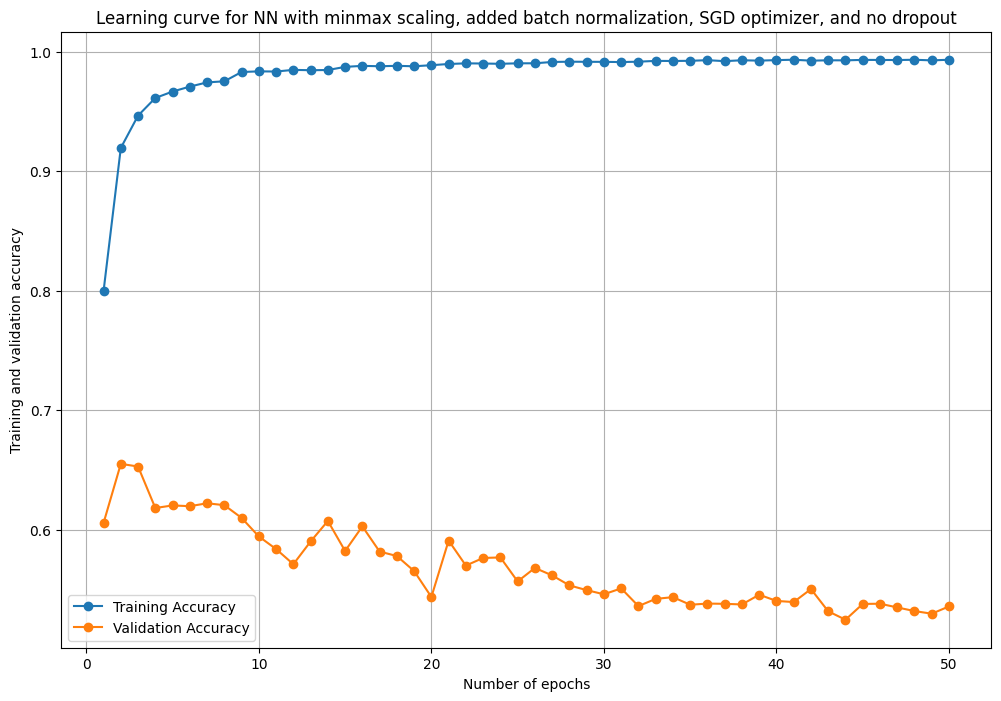

In [54]:
plot_accuracy(accu, title="NN with minmax scaling, added batch normalization, SGD optimizer, and no dropout")

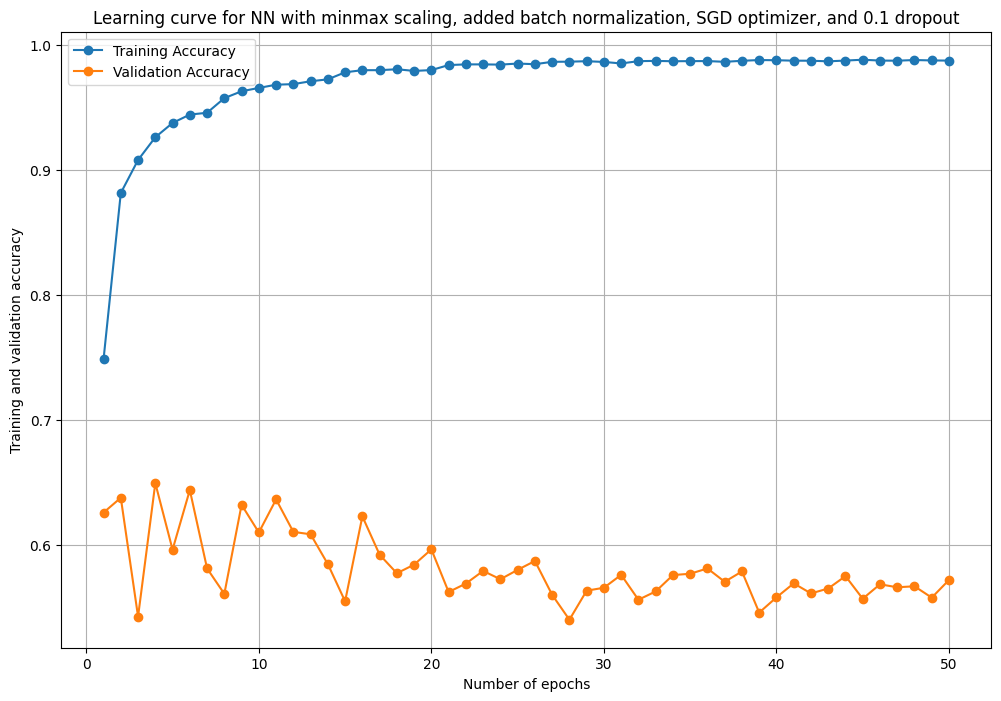

In [43]:
plot_accuracy(accu, title="NN with minmax scaling, added batch normalization, SGD optimizer, and 0.1 dropout")

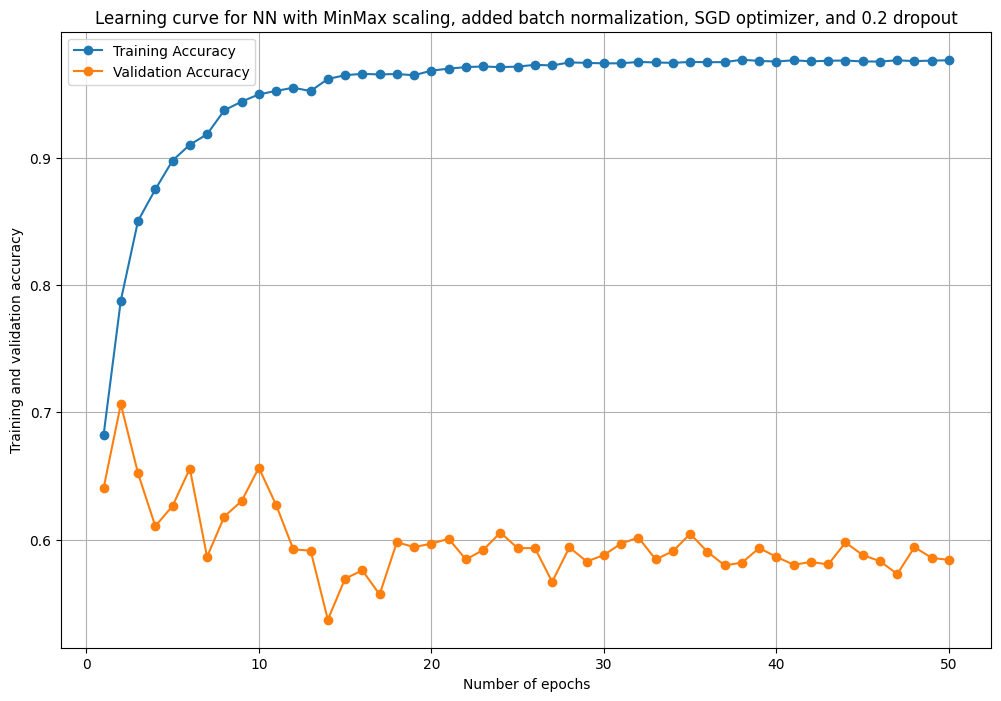

In [62]:
plot_accuracy(accu, title="NN with MinMax scaling, added batch normalization, SGD optimizer, and 0.2 dropout")

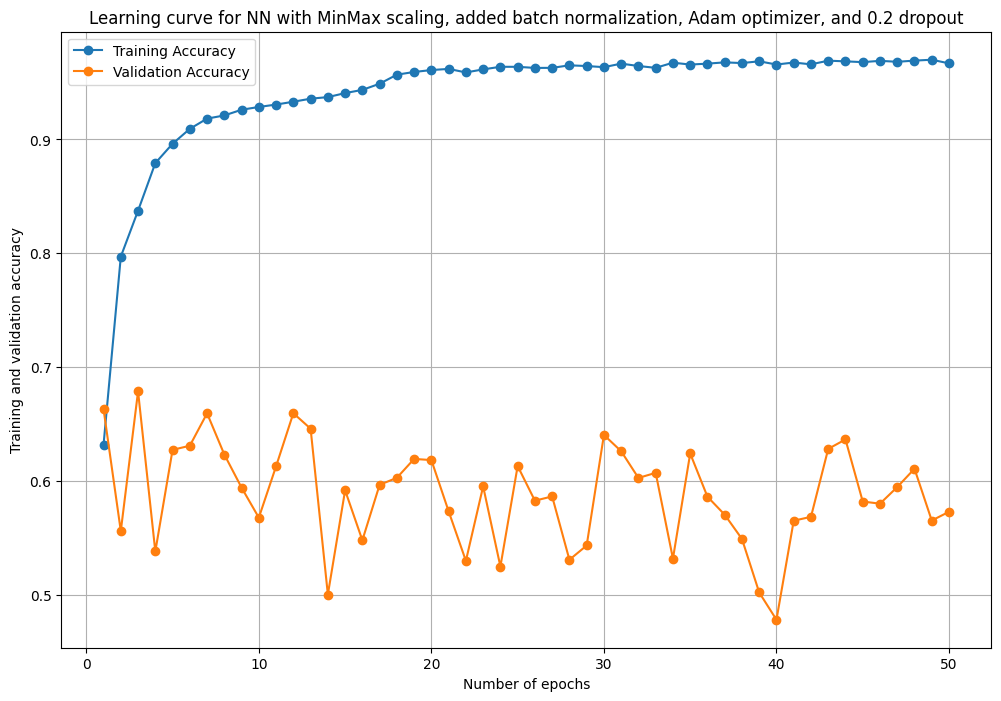

In [69]:
plot_accuracy(accu, title="NN with MinMax scaling, added batch normalization, Adam optimizer, and 0.2 dropout")

In [ ]:
with open("model.pickle", "wb") as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

# New Dataset

In [379]:
game_3_data = pd.read_csv("data/Sample_Game_3/Sample_Game_3_tracking.txt", sep=r"[;,:]", header=None, engine="python")
game_3_data.index =  range(1, len(game_3_data) + 1)

In [380]:
time = np.arange(0.04, (len(game_3_data) + 1) * 0.04, 0.04).round(2)
game_3_data.insert(1, "Time [s]", time)

In [381]:
columns = ['Frame', 'Time [s]', 'Home-Player11-x', 'Home-Player11-y', 'Home-Player1-x', 'Home-Player1-y', 'Home-Player2-x', 'Home-Player2-y',
       'Home-Player3-x', 'Home-Player3-y', 'Home-Player4-x', 'Home-Player4-y', 'Home-Player5-x', 'Home-Player5-y', 'Home-Player6-x', 'Home-Player6-y',
       'Home-Player7-x', 'Home-Player7-y', 'Home-Player8-x', 'Home-Player8-y', 'Home-Player9-x', 'Home-Player9-y', 'Home-Player10-x',
       'Home-Player10-y', 'Away-Player25-x', 'Away-Player25-y', 'Away-Player15-x', 'Away-Player15-y', 'Away-Player16-x',
       'Away-Player16-y', 'Away-Player17-x', 'Away-Player17-y', 'Away-Player18-x', 'Away-Player18-y', 'Away-Player19-x',
       'Away-Player19-y', 'Away-Player20-x', 'Away-Player20-y', 'Away-Player21-x', 'Away-Player21-y', 'Away-Player22-x',
       'Away-Player22-y', 'Away-Player23-x', 'Away-Player23-y', 'Away-Player24-x', 'Away-Player24-y', "Ball-x", "Ball-y"]

game_3_data.columns = columns

In [382]:
game_3_data.iloc[69660:, 2:23] #= game_3_data.iloc[:, :-2]   1,2

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,Home-Player5-y,Home-Player6-x,Home-Player6-y,Home-Player7-x,Home-Player7-y,Home-Player8-x,Home-Player8-y,Home-Player9-x,Home-Player9-y,Home-Player10-x
69661,0.91621,0.45134,0.65780,0.19980,0.62439,0.35977,0.68105,0.42499,0.63802,0.60269,...,0.21820,0.55159,0.34061,0.41786,0.31715,0.55376,0.43285,0.51321,0.52578,0.40556
69662,0.10142,0.50439,0.35847,0.73200,0.46702,0.92940,0.31514,0.44824,0.43353,0.25663,...,0.76629,0.49461,0.95937,0.49922,0.33150,0.39096,0.42326,0.49736,0.25678,0.46183
69663,0.10142,0.50439,0.35751,0.74598,0.46702,0.92940,0.31174,0.44864,0.43353,0.25663,...,0.78255,0.49461,0.95937,0.49922,0.33150,0.39275,0.42171,0.49736,0.25678,0.46780
69664,0.10142,0.50439,0.35658,0.76110,0.46702,0.92940,0.30815,0.44957,0.43353,0.25663,...,0.79914,0.49461,0.95937,0.49922,0.33150,0.39493,0.42174,0.49736,0.25678,0.47385
69665,0.10142,0.50439,0.35554,0.77082,0.46702,0.92940,0.30518,0.44958,0.43353,0.25663,...,0.81006,0.49461,0.95937,0.49922,0.33150,0.39584,0.42024,0.49736,0.25678,0.47776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,0.68471,0.57525,0.75401,0.64354,0.53380,0.70887,0.32991,0.62245,0.82597,0.81103
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,0.68336,0.57487,0.75437,0.64293,0.53414,0.70819,0.32904,0.62208,0.82624,0.81054
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,0.68111,0.57428,0.75448,0.64217,0.53414,0.70706,0.32904,0.62163,0.82605,0.80968
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,0.67772,0.57348,0.75491,0.64093,0.53584,0.70552,0.32798,0.62081,0.82536,0.80882


In [383]:
game_3_data = game_2_pre._fill_missing_with_interpolation_and_fill(game_3_data)

In [384]:
game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,Away-Player21-x,Away-Player21-y,Away-Player22-x,Away-Player22-y,Away-Player23-x,Away-Player23-y,Away-Player24-x,Away-Player24-y,Ball-x,Ball-y
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,0.41787,0.48086,0.41215,0.36689,0.47050,0.73219,0.48864,0.36357,0.50125,0.48725
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.41719,0.47864,0.41132,0.36169,0.47040,0.73204,0.48834,0.36362,0.50125,0.48725
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.41697,0.47824,0.41131,0.36072,0.47075,0.73229,0.48814,0.36372,0.50125,0.48725
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.41685,0.47815,0.41117,0.35930,0.47118,0.73266,0.48793,0.36278,0.50125,0.48725
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.41669,0.47749,0.41120,0.35910,0.47163,0.73287,0.48784,0.36240,0.50125,0.48725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.58877,0.56936,0.50218,0.65158,0.46978,0.62349,0.80792,0.27106,0.89207,0.50485
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.58787,0.56961,0.50180,0.65115,0.46970,0.62403,0.80712,0.27184,0.89207,0.50485
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.58668,0.57038,0.50116,0.65071,0.46929,0.62479,0.80582,0.27242,0.89207,0.50485
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.58525,0.57033,0.50031,0.65134,0.46866,0.62611,0.80444,0.27260,0.89207,0.50485


In [385]:
vel_acc_game_3_data = game_1_pre.vel_acc(game_3_data)
vel_acc_game_3_data

,Frame,Time [s],Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,1,0.04,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.08,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,3,0.12,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,4,0.16,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,5,0.20,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,143757,5750.28,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,143758,5750.32,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,143759,5750.36,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,143760,5750.40,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [386]:
game_3_ply_tra = vel_acc_game_3_data.iloc[:, 2:]
game_3_ply_tra

,Home-Player11-x,Home-Player11-y,Home-Player1-x,Home-Player1-y,Home-Player2-x,Home-Player2-y,Home-Player3-x,Home-Player3-y,Home-Player4-x,Home-Player4-y,...,P_21_velocity,P_21_acceleration,P_22_velocity,P_22_acceleration,P_23_velocity,P_23_acceleration,P_24_velocity,P_24_acceleration,Ball_velocity,Ball_acceleration
1,0.84722,0.52855,0.65268,0.24792,0.66525,0.46562,0.68103,0.59083,0.62405,0.80669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.84722,0.52855,0.65231,0.24513,0.66482,0.46548,0.68095,0.59054,0.62371,0.80594,...,0.058045,NaN,0.131646,NaN,0.004507,NaN,0.007603,NaN,0.0,NaN
3,0.84722,0.52855,0.65197,0.24387,0.66467,0.46537,0.68078,0.59035,0.62354,0.80601,...,0.011413,-1.165813,0.024251,-2.684858,0.010753,0.156149,0.005590,-0.050332,0.0,0.0
4,0.84722,0.52855,0.65166,0.24288,0.66460,0.46488,0.68063,0.58987,0.62318,0.80604,...,0.003750,-0.191568,0.035672,0.285521,0.014182,0.085724,0.024079,0.462228,0.0,0.0
5,0.84722,0.52855,0.65141,0.24251,0.66452,0.46469,0.68052,0.58934,0.62286,0.80626,...,0.016978,0.330698,0.005056,-0.765405,0.012415,-0.044179,0.009763,-0.357912,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.11993,0.51783,0.47808,0.45408,0.49691,0.77311,0.46373,0.62102,0.50927,0.27457,...,0.016508,0.052893,0.012260,0.120679,0.006828,0.061555,0.016900,-0.017704,0.0,0.0
143758,0.11993,0.51783,0.47786,0.45521,0.49701,0.77429,0.46381,0.62046,0.50913,0.27654,...,0.023352,0.171109,0.014346,0.052149,0.013647,0.170477,0.027933,0.275813,0.0,0.0
143759,0.11993,0.51783,0.47743,0.45709,0.49686,0.77555,0.46358,0.62117,0.50876,0.27762,...,0.035435,0.302072,0.019416,0.126758,0.021588,0.198528,0.035588,0.191374,0.0,0.0
143760,0.11993,0.51783,0.47669,0.45947,0.49676,0.77638,0.46306,0.62339,0.50808,0.27935,...,0.035772,0.008426,0.026450,0.175848,0.036566,0.374435,0.034792,-0.019892,0.0,0.0


In [387]:
game_3_player_data = game_1_pre.get_frames(game_3_ply_tra, columns=game_3_ply_tra.columns[0:46:2]).round(4).fillna(0)
game_3_player_data

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
1,0.8472,0.5286,0.0,0.0,0.6527,0.2479,0.0000,0.0000,0.6652,0.4656,...,0.0000,0.0000,0.4886,0.3636,0.0000,0.0000,0.5012,0.4872,0.0,0.0
2,0.8472,0.5286,0.0,0.0,0.6523,0.2451,0.0704,0.0000,0.6648,0.4655,...,0.0045,0.0000,0.4883,0.3636,0.0076,0.0000,0.5012,0.4872,0.0,0.0
3,0.8472,0.5286,0.0,0.0,0.6520,0.2439,0.0326,-0.9434,0.6647,0.4654,...,0.0108,0.1561,0.4881,0.3637,0.0056,-0.0503,0.5012,0.4872,0.0,0.0
4,0.8472,0.5286,0.0,0.0,0.6517,0.2429,0.0259,-0.1673,0.6646,0.4649,...,0.0142,0.0857,0.4879,0.3628,0.0241,0.4622,0.5012,0.4872,0.0,0.0
5,0.8472,0.5286,0.0,0.0,0.6514,0.2425,0.0112,-0.3693,0.6645,0.4647,...,0.0124,-0.0442,0.4878,0.3624,0.0098,-0.3579,0.5012,0.4872,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143757,0.1199,0.5178,0.0,0.0,0.4781,0.4541,0.0175,0.2063,0.4969,0.7731,...,0.0068,0.0616,0.8079,0.2711,0.0169,-0.0177,0.8921,0.5048,0.0,0.0
143758,0.1199,0.5178,0.0,0.0,0.4779,0.4552,0.0288,0.2816,0.4970,0.7743,...,0.0136,0.1705,0.8071,0.2718,0.0279,0.2758,0.8921,0.5048,0.0,0.0
143759,0.1199,0.5178,0.0,0.0,0.4774,0.4571,0.0482,0.4858,0.4969,0.7756,...,0.0216,0.1985,0.8058,0.2724,0.0356,0.1914,0.8921,0.5048,0.0,0.0
143760,0.1199,0.5178,0.0,0.0,0.4767,0.4595,0.0623,0.3524,0.4968,0.7764,...,0.0366,0.3744,0.8044,0.2726,0.0348,-0.0199,0.8921,0.5048,0.0,0.0


In [388]:
with open("data/Sample_Game_3/Sample_Game_3_events.json", "r") as f:
    data = json.load(f)

In [389]:
type_ = np.array([])
start_frame = np.array([])
end_frame = np.array([])

for i in data["data"]:
    t = i["type"]["name"]
    sf = i["start"]["frame"]
    ef = i["end"]["frame"]

    if t != "CARRY":   
        type_ = np.append(type_, t)
        start_frame = np.append(start_frame, sf)
        end_frame = np.append(end_frame, ef)


game_3_event_data = pd.DataFrame({"Type": type_, "Start Frame": start_frame.astype(np.int64), "End Frame": end_frame.astype(np.int64)})

In [390]:
game_3_event_data = game_3_event_data[~(game_3_event_data["Type"] == "FAULT RECEIVED")]

game_3_event_data = game_3_event_data.replace("RECOVERY", "BALL LOST")

In [391]:
game_3_event_data

,Type,Start Frame,End Frame
0,SET PIECE,361,361
1,PASS,361,377
2,PASS,384,426
3,PASS,465,507
4,PASS,530,580
...,...,...,...
2220,PASS,143190,143265
2221,PASS,143265,143290
2222,PASS,143406,143469
2223,PASS,143469,143532


In [138]:
game_3_event_data = fix_events(game_3_event_data)

NameError: name 'fix_events' is not defined

In [392]:
start_frames = game_3_event_data["Start Frame"].iloc[1:].to_numpy()
end_frames = game_3_event_data["End Frame"].iloc[1:].to_numpy()
event_types = game_3_event_data["Type"].iloc[1:].to_numpy()

assert start_frames.shape == end_frames.shape == event_types.shape

end = game_3_player_data.index[-1]
end_frames = np.minimum(end_frames, end)

frame_ranges = [np.arange(min(i, j), max(i, j) + 1) for i, j in zip(start_frames, end_frames)]
unique_indices  = np.unique(np.concatenate(frame_ranges))
game_3_event = pd.DataFrame(index=unique_indices, columns=["Type"])

for s, e, e_t in zip(start_frames, end_frames, event_types):
    game_3_event.loc[s:e, "Type"] = e_t

game_3_event = game_3_event.dropna()

In [393]:
# game_3_event = game_3_event[~(game_3_event["Type"] == "CARD")]
game_3_event#.drop()

,Type
361,PASS
362,PASS
363,PASS
364,PASS
365,PASS
...,...
143529,PASS
143530,PASS
143531,PASS
143532,PASS


In [394]:
# with open("model.pickle", "rb") as f:
#     loaded_model = pickle.load(f)

In [395]:
valid_indices = game_3_event.index.intersection(game_3_player_data.index)
X_3 = game_3_player_data.loc[valid_indices]
y_3 = game_3_event.loc[valid_indices, "Type"]

In [396]:
X_3

,Home-Player11-x,Home-Player11-y,P_11_velocity,P_11_acceleration,Home-Player1-x,Home-Player1-y,P_1_velocity,P_1_acceleration,Home-Player2-x,Home-Player2-y,...,P_23_velocity,P_23_acceleration,Away-Player24-x,Away-Player24-y,P_24_velocity,P_24_acceleration,Ball-x,Ball-y,Ball_velocity,Ball_acceleration
361,0.8422,0.5168,0.0088,-0.1068,0.6386,0.1946,0.0122,-0.0176,0.7347,0.3860,...,0.0154,0.0679,0.4871,0.3631,0.0048,0.0273,0.5012,0.4872,0.0000,0.0000
362,0.8423,0.5165,0.0086,-0.0036,0.6383,0.1942,0.0135,0.0312,0.7349,0.3867,...,0.0149,-0.0139,0.4873,0.3631,0.0045,-0.0070,0.5011,0.4872,0.0035,0.0877
363,0.8425,0.5162,0.0081,-0.0146,0.6379,0.1940,0.0107,-0.0694,0.7350,0.3874,...,0.0166,0.0424,0.4875,0.3630,0.0054,0.0217,0.5010,0.4872,0.0040,0.0125
364,0.8426,0.5158,0.0101,0.0507,0.6376,0.1936,0.0115,0.0201,0.7352,0.3879,...,0.0150,-0.0378,0.4878,0.3630,0.0063,0.0218,0.5008,0.4872,0.0040,0.0006
365,0.8428,0.5155,0.0105,0.0109,0.6373,0.1933,0.0108,-0.0171,0.7353,0.3885,...,0.0166,0.0395,0.4881,0.3631,0.0078,0.0371,0.5006,0.4872,0.0040,-0.0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143529,0.1199,0.5178,0.0000,0.0000,0.4281,0.4874,0.0173,0.0295,0.4386,0.7978,...,0.0080,-0.0042,0.7547,0.2033,0.0330,0.0328,0.8771,0.5331,0.1522,0.0000
143530,0.1199,0.5178,0.0000,0.0000,0.4287,0.4870,0.0178,0.0125,0.4390,0.7972,...,0.0082,0.0061,0.7558,0.2026,0.0326,-0.0092,0.8798,0.5277,0.1521,-0.0028
143531,0.1199,0.5178,0.0000,0.0000,0.4293,0.4866,0.0186,0.0191,0.4393,0.7965,...,0.0084,0.0034,0.7569,0.2018,0.0347,0.0515,0.8826,0.5222,0.1522,0.0028
143532,0.1199,0.5178,0.0000,0.0000,0.4299,0.4862,0.0185,-0.0021,0.4396,0.7960,...,0.0080,-0.0087,0.7580,0.2010,0.0345,-0.0045,0.8853,0.5168,0.1522,0.0000


In [397]:
# X_new = game_1_pre.expand_dataset(dataset=X_new, look_back=50)
# y_new = game_1_pre.expand_dataset(dataset=y_new, look_back=50)

In [398]:
np.unique(y_1, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([10006,  2871,     4,   132, 28247,    12,   619], dtype=int64))

In [399]:
np.unique(y_2, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SET PIECE',
        'SHOT'], dtype=object),
 array([ 7681,  2454,     6,   172, 32469,     9,   543], dtype=int64))

In [400]:
np.unique(y_3, return_counts=True)

(array(['BALL LOST', 'BALL OUT', 'CARD', 'CHALLENGE', 'PASS', 'SHOT'],
       dtype=object),
 array([11080,  2662,     1,   186, 43053,   403], dtype=int64))

In [401]:
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1)
y_2_encoded = label_encoder.transform(y_2)
y_3_encoded = label_encoder.transform(y_3)

In [402]:
scaler = MinMaxScaler()
X_1_scaled = scaler.fit_transform(X_1)
X_2_scaled = scaler.transform(X_2)
X_3_scaled = scaler.transform(X_3)

In [403]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(41891, 92)
(43334, 92)
(57385, 92)


In [404]:
# TEMP SOLUTIONS
X_1_scaled = X_1_scaled[:41850]
y_1_encoded = y_1_encoded[:41850]

X_2_scaled = X_2_scaled[:43300]
y_2_encoded = y_2_encoded[:43300]

X_3_scaled = X_3_scaled[:57350]
y_3_encoded = y_3_encoded[:57350]

In [405]:
print(X_1_scaled.shape)
print(X_2_scaled.shape)
print(X_3_scaled.shape)

(41850, 92)
(43300, 92)
(57350, 92)


In [406]:
assert X_3_scaled.shape[0] == y_3_encoded.shape[0]

In [407]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [408]:
np.unique(y_1_encoded).shape, np.unique(y_2_encoded).shape, np.unique(y_3_encoded).shape

((7,), (7,), (6,))

In [417]:
assert X_1_scaled.shape[1] == X_2_scaled.shape[1] == X_3_scaled.shape[1]
# assert np.unique(y_1).shape == np.unique(y_2).shape == np.unique(y_3).shape

input_size = X_1_scaled.shape[1]
hidden_size = 256
num_layers = 2
num_classes = np.unique(y_1_encoded).shape[0]
sequence_length = 25
learning_rate = 0.001
batch_size = 256
num_epochs = 80

In [418]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, sequence_task=True):
        self.features = torch.tensor(features.values if hasattr(features, "values") else features,
                                   dtype=torch.float32)
        self.labels = torch.tensor(labels.values if hasattr(labels, "values") else labels,
                                 dtype=torch.long)
        self.sequence_task = sequence_task
        
        # Validate shapes
        assert self.features.shape[0] == self.labels.shape[0], \
            f"Number of samples mismatch: features {self.features.shape[0]}, labels {self.labels.shape[0]}"
        
        if sequence_task:
            assert self.features.shape[1] == self.labels.shape[1], \
                f"Sequence length mismatch: features {self.features.shape[1]}, labels {self.labels.shape[1]}"
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Reshape the NumPy array
X_1_reshaped = X_1_scaled.reshape(-1, sequence_length, input_size)
y_1_reshaped = y_1_encoded.reshape(-1, sequence_length)

X_2_reshaped = X_2_scaled.reshape(-1, sequence_length, input_size)
y_2_reshaped = y_2_encoded.reshape(-1, sequence_length) 

X_3_reshaped = X_3_scaled.reshape(-1, sequence_length, input_size)
y_3_reshaped = y_3_encoded.reshape(-1, sequence_length) 

# Create DataLoaders
training_dataset = CustomDataset(X_1_reshaped, y_1_reshaped)
validation_dataset = CustomDataset(X_2_reshaped, y_2_reshaped)
testing_dataset = CustomDataset(X_3_reshaped, y_3_reshaped)

train_loader = DataLoader(
    dataset=training_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

validation_loader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

test_loader = DataLoader(
    dataset=testing_dataset, 
    batch_size=batch_size, 
    shuffle=False,
)

In [419]:
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Seq2SeqLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        self.input_bn = nn.BatchNorm1d(input_size)
        
        # Define encoder and decoder
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(num_classes, hidden_size, num_layers, batch_first=True)
        
        self.hidden_bn = nn.BatchNorm1d(hidden_size)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.encoder.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
                
        for name, param in self.decoder.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
       
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
                    
    def forward(self, x, target_length=None):
        # Add target_length parameter or use x.size(1) as default
        if target_length is None:
            target_length = x.size(1)  # Use input sequence length as default
            
        batch_size = x.size(0)
        
        # x shape: [batch_size, seq_len, features]
        # Transpose to: [batch_size, features, seq_len]
        x = x.transpose(1, 2)
        x = self.input_bn(x)
        # Transpose back: [batch_size, seq_len, features]
        x = x.transpose(1, 2)
        
        # Encoder
        _, (h_n, c_n) = self.encoder(x)
        
        # Decoder
        decoder_input = torch.zeros(batch_size, 1, self.num_classes).to(x.device)
        decoder_hidden = (h_n, c_n)
        outputs = []
        
        for t in range(target_length):
            out, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            
            # out shape: [batch_size, 1, hidden_size]
            # Transpose to: [batch_size, hidden_size, 1]
            out = out.transpose(1, 2)
            out = self.hidden_bn(out)
            # Transpose back: [batch_size, 1, hidden_size]
            out = out.transpose(1, 2)
            
            prediction = self.fc(out.squeeze(1)).unsqueeze(1)
            outputs.append(prediction)
            decoder_input = prediction
            
        return torch.cat(outputs, dim=1)

In [420]:
model = Seq2SeqLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)
model

Seq2SeqLSTM(
  (input_bn): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): LSTM(92, 256, num_layers=2, batch_first=True)
  (decoder): LSTM(7, 256, num_layers=2, batch_first=True)
  (hidden_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

In [421]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)

accu = {"training_accuracy": [], "validation_accuracy": [], "testing_accuracy": []}

train_dataset_len = len(train_loader.dataset)
val_dataset_len = len(validation_loader.dataset)

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    
    val_acc = 0
    val_loss = 0

    val_preds = []
    val_labels = []
    
    model.train()
    
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
                
        outputs = model(data)
        outputs = outputs.permute(0, 2, 1)
        
        loss = criterion(outputs, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        _, pred = torch.max(outputs, 1)
        train_acc += (pred == label).float().sum().item()

    train_loss /= len(train_loader)
    train_accuracy = train_acc / (train_dataset_len * sequence_length)
    accu["training_accuracy"].append(train_accuracy)

    model.eval()
    with torch.no_grad():
        for data, label in validation_loader:
            data, label = data.to(device), label.to(device)
        
            outputs = model(data)
            outputs = outputs.permute(0, 2, 1)
            
            loss = criterion(outputs, label)
            val_loss += loss.item()
            
            _, pred = torch.max(outputs, 1)
            val_acc += (pred == label).float().sum().item()

            val_preds.extend(pred.cpu().numpy().flatten())
            val_labels.extend(label.cpu().numpy().flatten())

    val_loss /= len(validation_loader)
    val_accuracy = val_acc / (val_dataset_len * sequence_length)
    accu["validation_accuracy"].append(val_accuracy)

    val_precision = precision_score(val_labels, val_preds, average="weighted", zero_division=0)
    val_recall = recall_score(val_labels, val_preds, average="weighted", zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average="weighted", zero_division=0)
    
    l_rate = optimizer.param_groups[0]["lr"]
    # scheduler.step(val_loss)
    
    print(f"Epoch[{epoch + 1}] | "
          f"training accuracy: {train_accuracy * 100:0.2f}% | "
          f"validation accuracy: {val_accuracy * 100:0.2f}% | "
          f"train loss: {train_loss:.4f} | "
          f"val loss: {val_loss:.4f} | "
          f"learning rate: {l_rate:.6f} | " 
          f"val precision: {val_precision * 100:0.2f}% | val recall: {val_recall * 100:0.2f}% | val f1: {val_f1 * 100:0.2f}%")

Epoch[1] | training accuracy: 47.30% | validation accuracy: 72.11% | train loss: 1.5556 | val loss: 1.1429 | learning rate: 0.001000 | val precision: 59.93% | val recall: 72.11% | val f1: 64.36%
Epoch[2] | training accuracy: 67.18% | validation accuracy: 74.62% | train loss: 0.9804 | val loss: 0.9434 | learning rate: 0.001000 | val precision: 60.31% | val recall: 74.62% | val f1: 64.52%
Epoch[3] | training accuracy: 69.03% | validation accuracy: 72.88% | train loss: 0.8946 | val loss: 0.9478 | learning rate: 0.001000 | val precision: 60.77% | val recall: 72.88% | val f1: 65.03%
Epoch[4] | training accuracy: 69.01% | validation accuracy: 72.99% | train loss: 0.8373 | val loss: 0.8907 | learning rate: 0.001000 | val precision: 61.82% | val recall: 72.99% | val f1: 65.81%
Epoch[5] | training accuracy: 71.66% | validation accuracy: 73.51% | train loss: 0.7705 | val loss: 0.8888 | learning rate: 0.001000 | val precision: 61.78% | val recall: 73.51% | val f1: 65.54%
Epoch[6] | training accur

In [335]:
test_acc = 0
test_loss = 0
test_dataset_len = len(test_loader.dataset)

model.eval()

with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        
        outputs = model(data)
        outputs = outputs.permute(0, 2, 1)

        test_loss += criterion(outputs, label).item()
        
        _, pred = torch.max(outputs, 1)
        test_acc += (pred == label).float().sum().item()

    test_loss /= len(test_loader)
    test_accuracy = test_acc / (test_dataset_len * sequence_length)
    accu["testing_accuracy"].append(test_accuracy)

print(f"Accuracy on test set: {test_accuracy * 100:.2f}%")

Accuracy on test set: 59.19%


In [422]:
def plot_accuracy(accuracy, title=""):
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.plot(list(range(1, num_epochs + 1)), accuracy["training_accuracy"], marker="o", label="Training Accuracy")
    ax.plot(list(range(1, num_epochs + 1)), accuracy["validation_accuracy"], marker="o", label="Validation Accuracy")
    # ax.plot(list(range(1, num_epochs + 1)), accuracy["testing_accuracy"], marker="o", label="Testing Accuracy")

    ax.set_xlabel("Number of epochs")
    ax.set_ylabel("Training and validation accuracy")
    ax.set_title(f"Learning curve for {title}")
    
    ax.grid(True)
    ax.legend()
    
    plt.show()

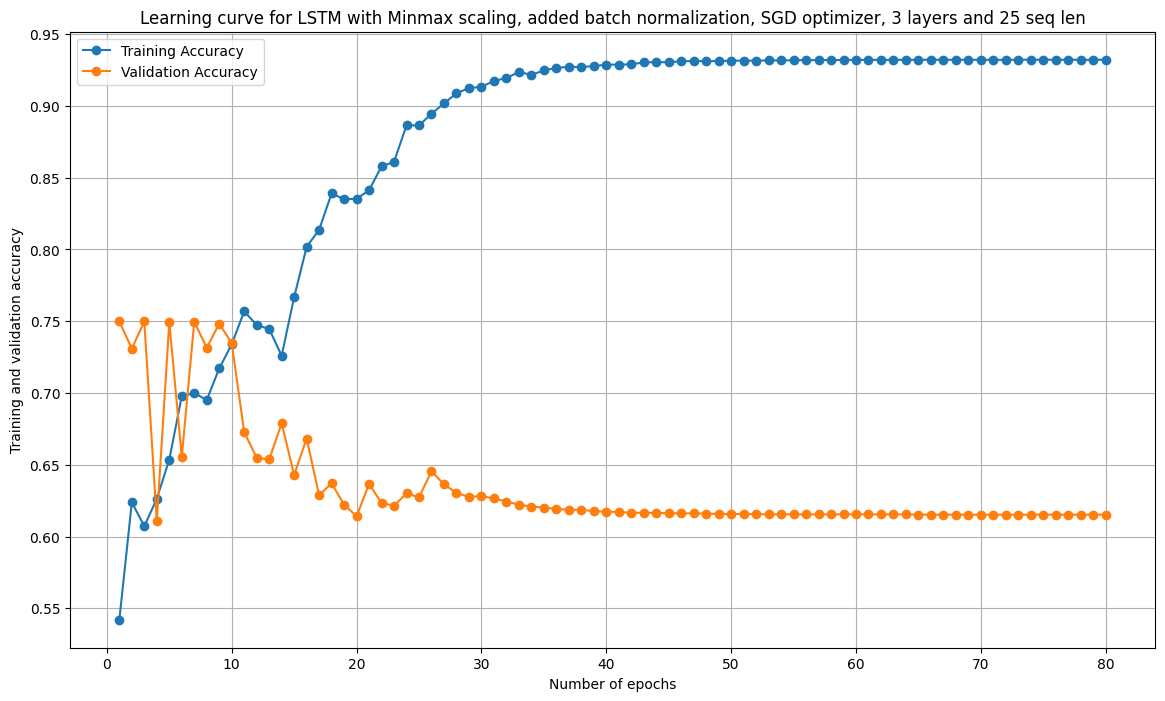

In [416]:
plot_accuracy(accu, title="LSTM with Minmax scaling, added batch normalization, SGD optimizer, 3 layers and 25 seq len")

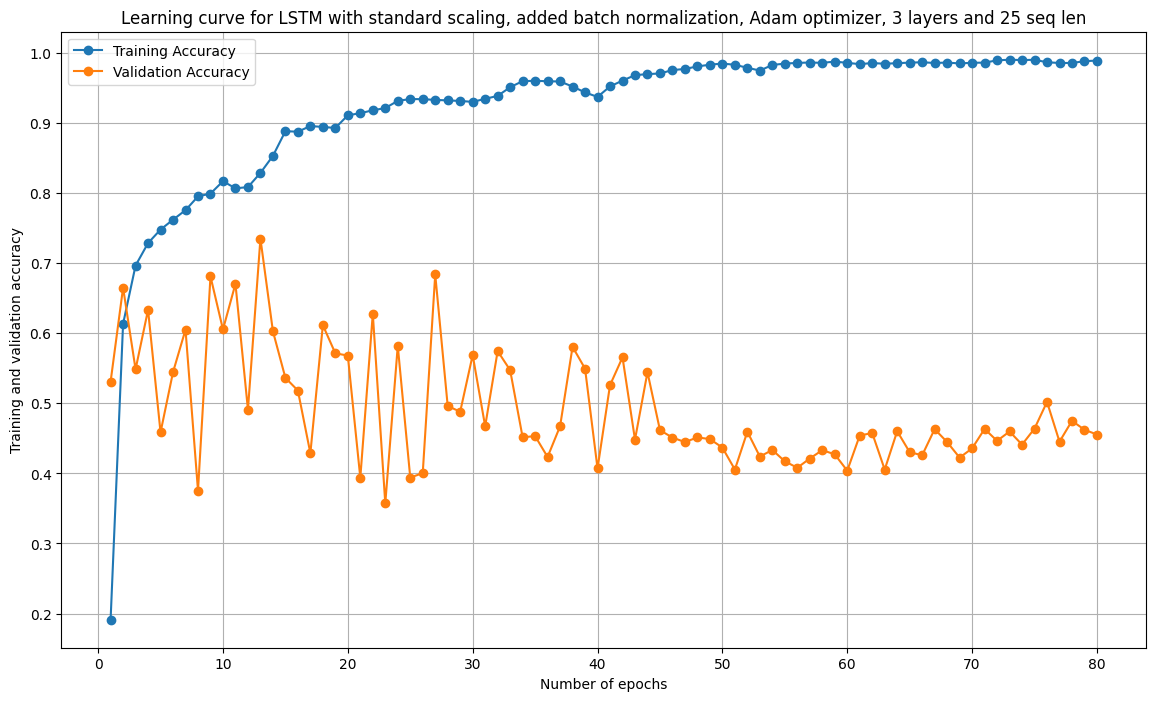

In [281]:
plot_accuracy(accu, title="LSTM with standard scaling, added batch normalization, Adam optimizer, 3 layers and 25 seq len")

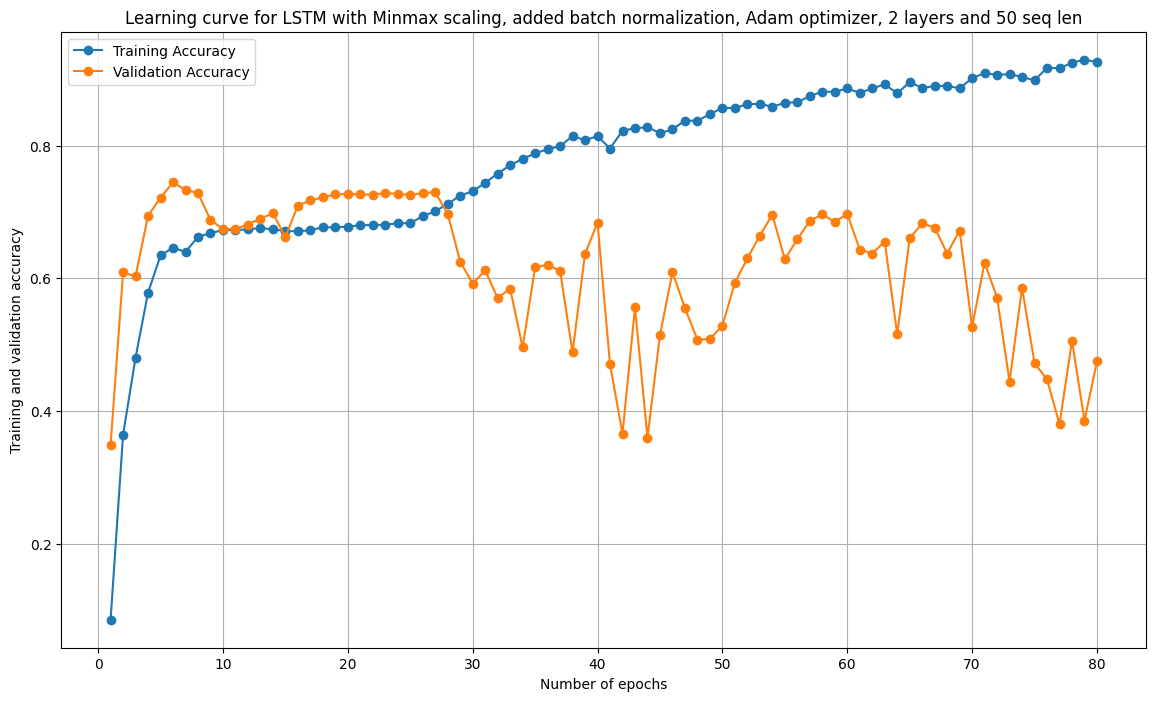

In [159]:
plot_accuracy(accu, title="LSTM with Minmax scaling, added batch normalization, Adam optimizer, 2 layers and 50 seq len")

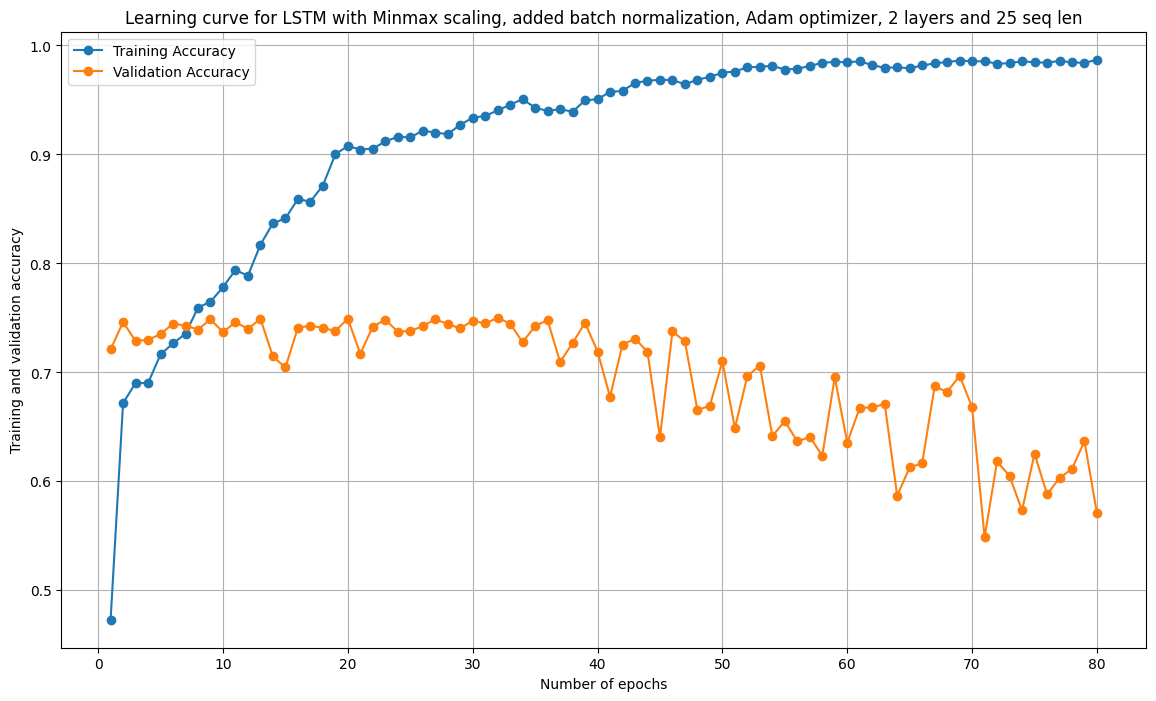

In [423]:
plot_accuracy(accu, title="LSTM with Minmax scaling, added batch normalization, Adam optimizer, 2 layers and 25 seq len")

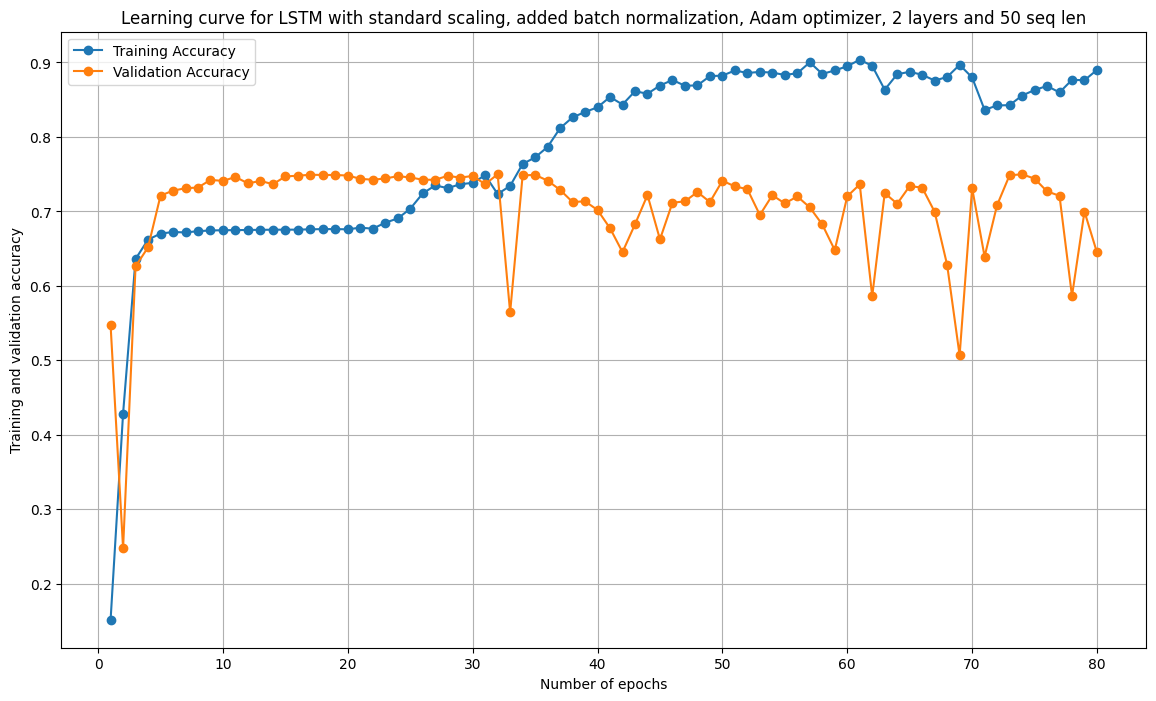

In [196]:
plot_accuracy(accu, title="LSTM with standard scaling, added batch normalization, Adam optimizer, 2 layers and 50 seq len")

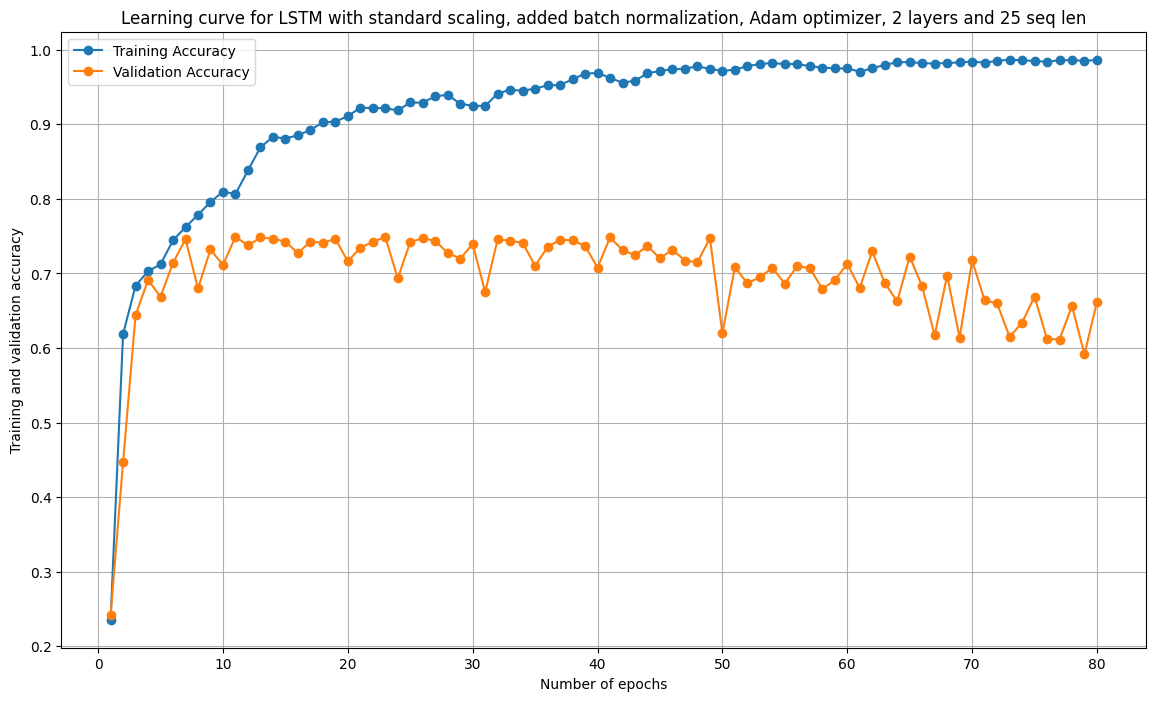

In [220]:
plot_accuracy(accu, title="LSTM with standard scaling, added batch normalization, Adam optimizer, 2 layers and 25 seq len")

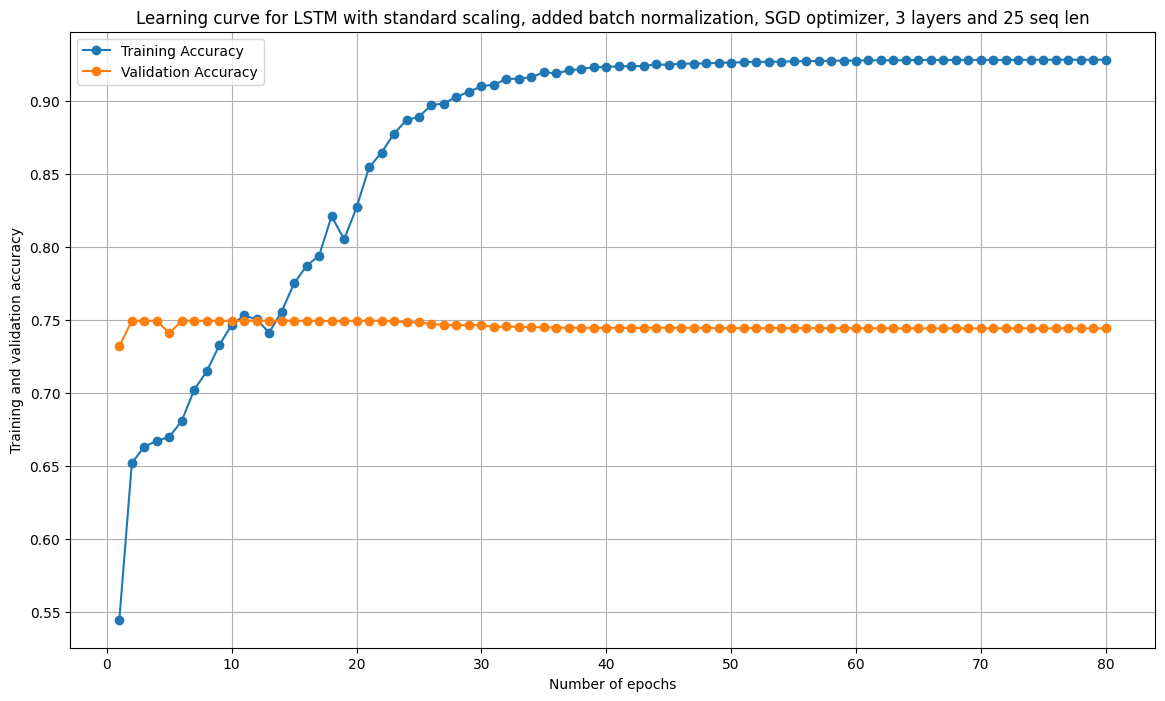

In [289]:
plot_accuracy(accu, title="LSTM with standard scaling, added batch normalization, SGD optimizer, 3 layers and 25 seq len")

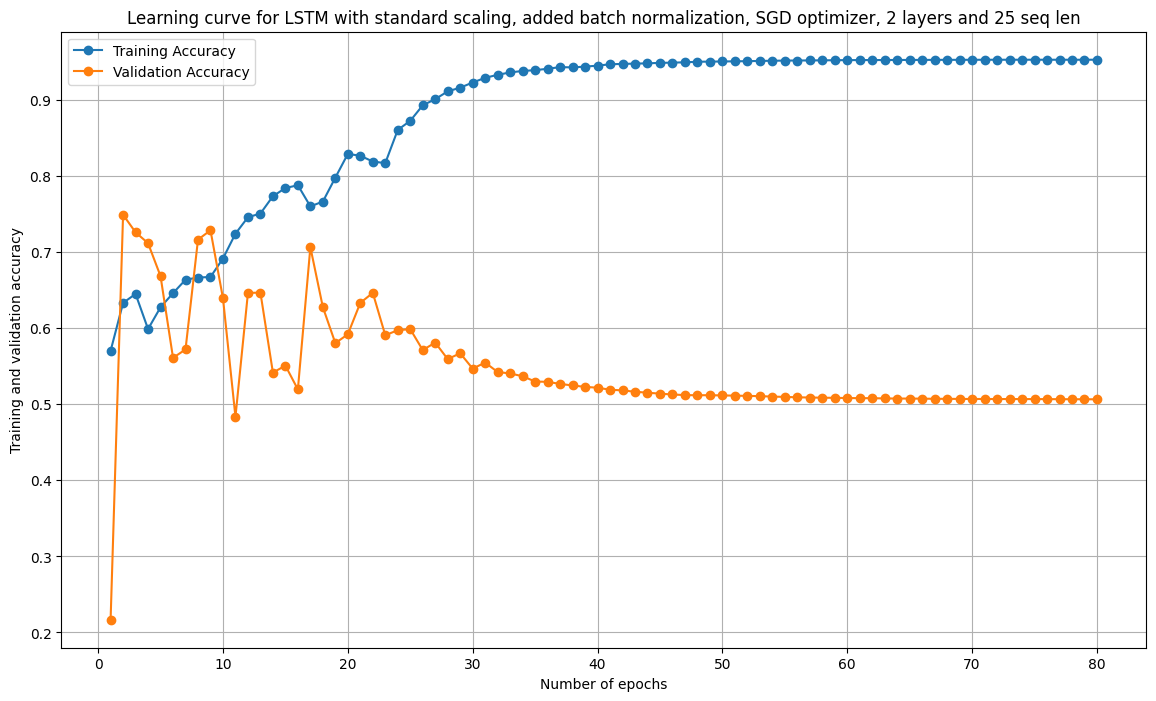

In [297]:
plot_accuracy(accu, title="LSTM with standard scaling, added batch normalization, SGD optimizer, 2 layers and 25 seq len")